# Jordan Taylor
# Week 08 Homework
### 8.1

Last week you practiced single band raster calculations using Sentinel-2 satellite remote sensing data. This week you will practice working with the multiple bands associated with Sentinel-2 data in order to create RGB composites and other band manipulations. 

The Sentinel-2 bands are as follows:

![_._](img/sentinel-2-bands.jpg)

You will compare RGB and NDVI images from May 2018 (```data/pre-woolsey-fire/```) and February 2019 (```data/post-woolsey-fire```) over the Santa Monica Mountains which correspond to pre and post-Woolsey fire. The Woolsey fire occured in November 2018. 

1. Create an **automated workflow** which loads, stacks and cleans the bands of a single Sentinel-2 date. 
2. Run this workflow for both dates: pre and post Woolsey fire.
3. Map the RGB composites for both dates.
4. Calculate the NDVI and map both dates.
5. Write a few sentences of what differences you see between the RGB/NDVI maps. 




In [88]:
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
from shapely.geometry import mapping
from glob import glob

import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns
from shapely.geometry import mapping
sns.set(font_scale=1.5, style="white")

# #1

In [89]:
pre_fire= os.path.join("data","pre-woolsey-fire")

pre_fire_2= glob(os.path.join(pre_fire,"*.tiff"))

In [90]:
#sorting the data for pre-fire

pre_fire_2.sort()
pre_fire_2

['data/pre-woolsey-fire/2018-05-14-00:00_2018-05-14-23:59_Sentinel-2_L2A_B01_(Raw).tiff',
 'data/pre-woolsey-fire/2018-05-14-00:00_2018-05-14-23:59_Sentinel-2_L2A_B02_(Raw).tiff',
 'data/pre-woolsey-fire/2018-05-14-00:00_2018-05-14-23:59_Sentinel-2_L2A_B03_(Raw).tiff',
 'data/pre-woolsey-fire/2018-05-14-00:00_2018-05-14-23:59_Sentinel-2_L2A_B04_(Raw).tiff',
 'data/pre-woolsey-fire/2018-05-14-00:00_2018-05-14-23:59_Sentinel-2_L2A_B05_(Raw).tiff',
 'data/pre-woolsey-fire/2018-05-14-00:00_2018-05-14-23:59_Sentinel-2_L2A_B06_(Raw).tiff',
 'data/pre-woolsey-fire/2018-05-14-00:00_2018-05-14-23:59_Sentinel-2_L2A_B07_(Raw).tiff',
 'data/pre-woolsey-fire/2018-05-14-00:00_2018-05-14-23:59_Sentinel-2_L2A_B08_(Raw).tiff',
 'data/pre-woolsey-fire/2018-05-14-00:00_2018-05-14-23:59_Sentinel-2_L2A_B09_(Raw).tiff',
 'data/pre-woolsey-fire/2018-05-14-00:00_2018-05-14-23:59_Sentinel-2_L2A_B11_(Raw).tiff',
 'data/pre-woolsey-fire/2018-05-14-00:00_2018-05-14-23:59_Sentinel-2_L2A_B12_(Raw).tiff',
 'data/pre

# #2

In [91]:
post_fire= os.path.join("data","post-woolsey-fire")

post_fire_2= glob(os.path.join(post_fire,"*.tiff"))

In [92]:
#sorting the data for post-fire

post_fire_2.sort()
post_fire_2

['data/post-woolsey-fire/2019-02-08-00:00_2019-02-08-23:59_Sentinel-2_L2A_B01_(Raw).tiff',
 'data/post-woolsey-fire/2019-02-08-00:00_2019-02-08-23:59_Sentinel-2_L2A_B02_(Raw).tiff',
 'data/post-woolsey-fire/2019-02-08-00:00_2019-02-08-23:59_Sentinel-2_L2A_B03_(Raw).tiff',
 'data/post-woolsey-fire/2019-02-08-00:00_2019-02-08-23:59_Sentinel-2_L2A_B04_(Raw).tiff',
 'data/post-woolsey-fire/2019-02-08-00:00_2019-02-08-23:59_Sentinel-2_L2A_B05_(Raw).tiff',
 'data/post-woolsey-fire/2019-02-08-00:00_2019-02-08-23:59_Sentinel-2_L2A_B06_(Raw).tiff',
 'data/post-woolsey-fire/2019-02-08-00:00_2019-02-08-23:59_Sentinel-2_L2A_B07_(Raw).tiff',
 'data/post-woolsey-fire/2019-02-08-00:00_2019-02-08-23:59_Sentinel-2_L2A_B08_(Raw).tiff',
 'data/post-woolsey-fire/2019-02-08-00:00_2019-02-08-23:59_Sentinel-2_L2A_B09_(Raw).tiff',
 'data/post-woolsey-fire/2019-02-08-00:00_2019-02-08-23:59_Sentinel-2_L2A_B11_(Raw).tiff',
 'data/post-woolsey-fire/2019-02-08-00:00_2019-02-08-23:59_Sentinel-2_L2A_B12_(Raw).tiff',

In [93]:
sm_boundary = os.path.join("data","greater-samo-area.geojson")
samo_boundary = gpd.read_file(sm_boundary)

In [94]:
print(samo_boundary.crs)

epsg:4326


In [95]:
pre_crs = rxr.open_rasterio(pre_fire_2[0], masked=True).squeeze().rio.crs
pre_crs

CRS.from_epsg(4326)

In [96]:
post_crs = rxr.open_rasterio(post_fire_2[0], masked=True).squeeze().rio.crs
post_crs

CRS.from_epsg(4326)

In [97]:
#reprojecting

samo_boundary_2 = samo_boundary.to_crs(pre_crs)

In [98]:
def open_clean_band(band_path, clip_extent, valid_range=None):
    """A function that opens a Landsat band as an (rio)xarray object

    Parameters
    ----------
    band_path : list
        A list of paths to the tif files that you wish to combine.

    clip_extent : geopandas geodataframe
        A geodataframe containing the clip extent of interest. NOTE: this will 
        fail if the clip extent is in a different CRS than the raster data.

    valid_range : tuple (optional)
        The min and max valid range for the data. All pixels with values outside
        of this range will be masked.

    Returns
    -------
    An single xarray object with the Landsat band data.

    """

    try:
        clip_bound = clip_extent.geometry
    except Exception as err:
        print("Oops, I need a geodataframe object for this to work.")
        print(err)

    cleaned_band = rxr.open_rasterio(band_path,
                                     masked=True).rio.clip(clip_bound,
                                                           from_disk=True).squeeze()

    # Only mask the data if a valid range tuple is provided
    if valid_range:
        mask = ((landsat_post_xr_clip < valid_range[0]) | (
            landsat_post_xr_clip > valid_range[1]))
        cleaned_band = landsat_post_xr_clip.where(
            ~xr.where(mask, True, False))

    return cleaned_band

In [99]:
#defining the empty array for the for loop (pre-fire):

pre_all_bands = []

for i, aband in enumerate(pre_fire_2):
    cleaned = open_clean_band(aband, samo_boundary_2)
    # This line below is only needed if you wish to stack and plot your data
    cleaned["band"] = i+1
    pre_all_bands.append(cleaned)

In [100]:
pre_fire_data = xr.concat(pre_all_bands, dim="band")

In [101]:
#defining the empty array for the for loop (post-fire):

post_all_bands = []

for i, aband in enumerate(post_fire_2):
    cleaned_postfire = open_clean_band(aband, samo_boundary_2)
    cleaned_postfire["band"] = i+1
    post_all_bands.append(cleaned)

In [102]:
post_fire_data = xr.concat(post_all_bands, dim="band")

# #3

In [103]:
#3 Map the RGB composites for both dates.

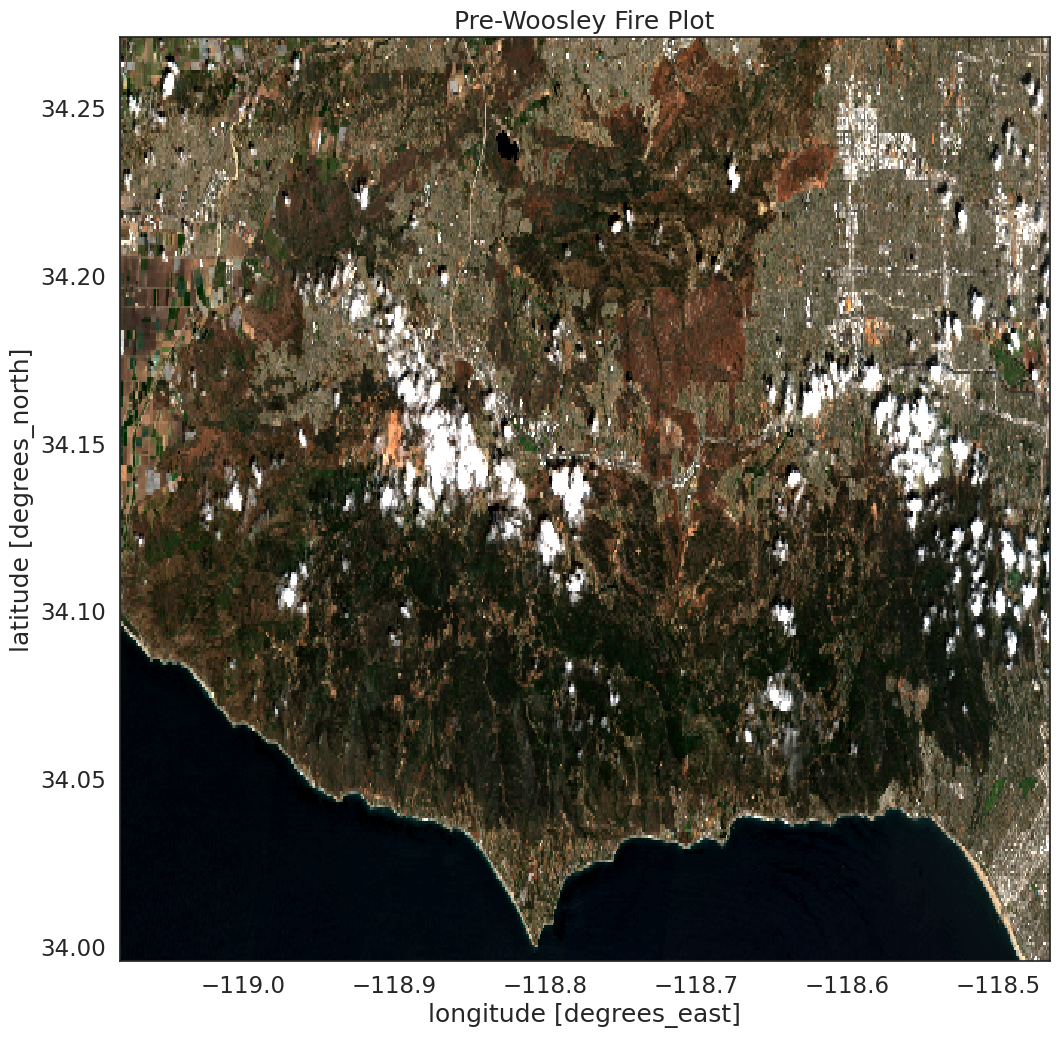

In [104]:
#pre-fire plot
pre_fire_rgb_plot = (pre_fire_data[[3,2,1],:,:])
pre_fire_rgb_plot.plot.imshow(rgb="band",robust=True,figsize=(12,12))
plt.title("Pre-Woosley Fire Plot")
plt.show()

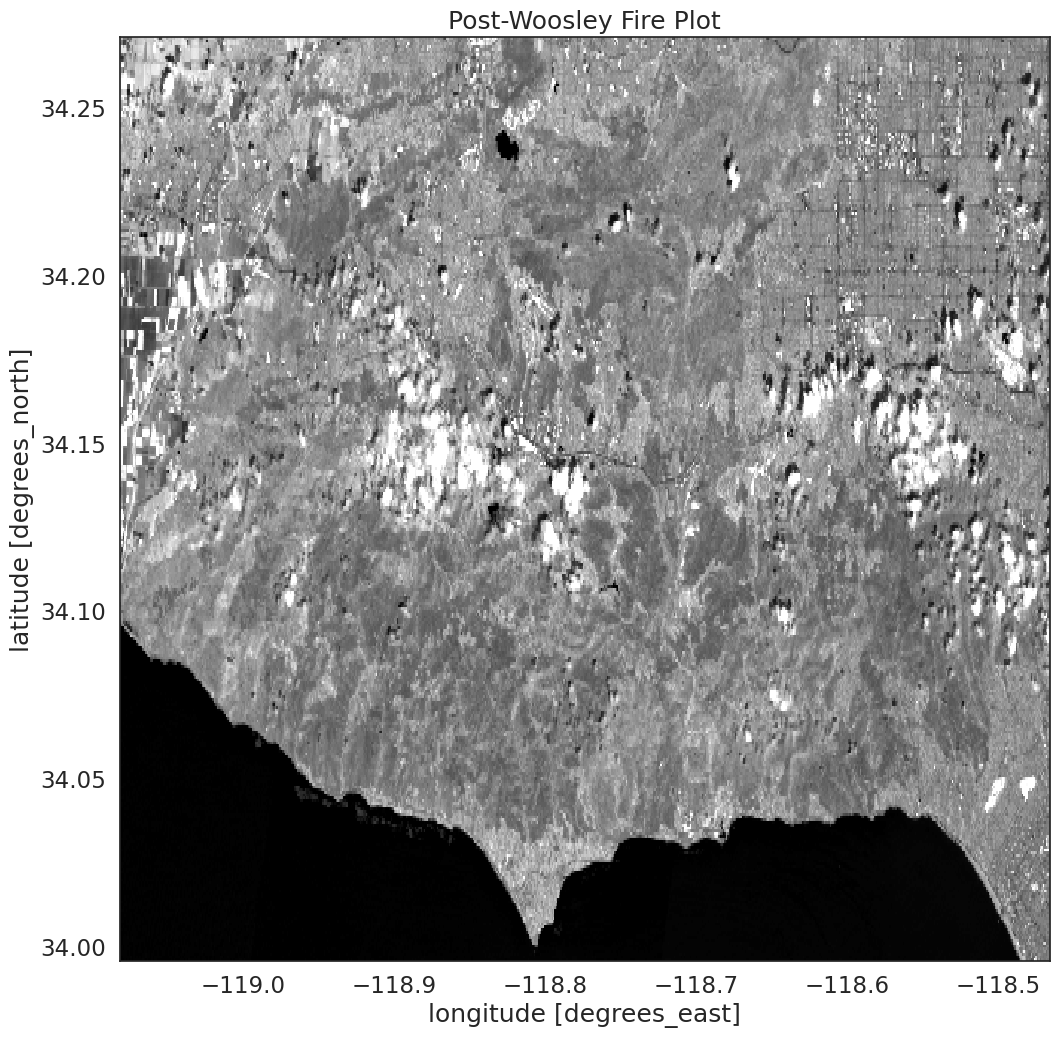

In [106]:
#post-fire plot
post_fire_rgb_plot = (post_fire_data[[3,2,1],:,:])
post_fire_rgb_plot.plot.imshow(rgb="band",robust=True,figsize=(12,12))
plt.title("Post-Woosley Fire Plot")
plt.show()

#note - unsure why my post-fire plot is in grayscale?

# #4

In [ ]:
#4 Calculate the NDVI and map both dates.

In [112]:
nir = pre_fire_data[7]
red = pre_fire_data[3] 
ndvi = (nir.astype(float) - red.astype(float)) / (nir.astype(float) + red.astype(float))
ndvi

<xarray.DataArray (y: 337, x: 625)>
array([[ 0.52941176,  0.48717949,  0.2173913 , ...,  0.00787402,
         0.0619469 ,  0.09803922],
       [ 0.46666667,  0.27659574,  0.18644068, ...,  0.02824859,
         0.06382979,  0.05      ],
       [ 0.27619048,  0.24210526,  0.20754717, ...,  0.03267974,
         0.08695652,  0.2       ],
       ...,
       [-0.06666667,  0.        , -0.06666667, ...,  0.23595506,
         0.24      ,  0.23214286],
       [ 0.        ,  0.        , -0.06666667, ...,  0.21212121,
         0.24271845,  0.18867925],
       [-0.05882353, -0.06666667, -0.06666667, ...,  0.27272727,
         0.2826087 ,  0.15789474]])
Coordinates:
  * x            (x) float64 -119.1 -119.1 -119.1 ... -118.5 -118.5 -118.5
  * y            (y) float64 34.27 34.27 34.27 34.27 ... 34.0 34.0 34.0 34.0
    spatial_ref  int64 0

In [113]:
#NDVI Calculations:

Max NDVI: <xarray.DataArray ()>
array(0.92941176)
Coordinates:
    spatial_ref  int64 0
Mean NDVI: <xarray.DataArray ()>
array(0.32073293)
Coordinates:
    spatial_ref  int64 0
Median NDVI: 0.33858267716535434
Min NDVI: <xarray.DataArray ()>
array(-0.35)
Coordinates:
    spatial_ref  int64 0


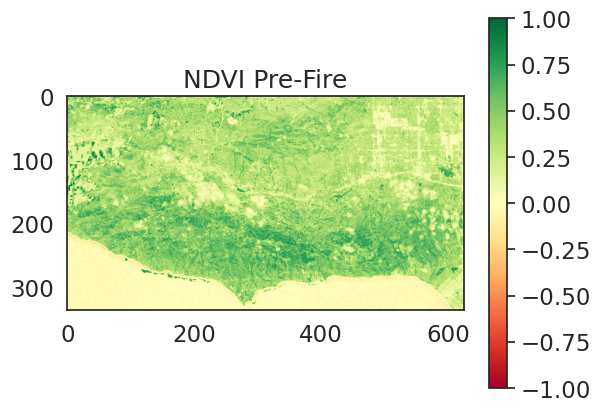

In [122]:
print('Max NDVI: {m}'.format(m=ndvi.max()))
print('Mean NDVI: {m}'.format(m=ndvi.mean()))
print('Median NDVI: {m}'.format(m=np.median(ndvi)))
print('Min NDVI: {m}'.format(m=ndvi.min()))

plt.imshow(ndvi, cmap="RdYlGn", vmin=-1, vmax=1)
plt.colorbar()
plt.title("NDVI Pre-Fire")
plt.show()

In [123]:
nir_post = post_fire_data[7]
red_post = post_fire_data[3] 
ndvi_post = (nir_post.astype(float) - red_post.astype(float)) / (nir_post.astype(float) + red_post.astype(float))
ndvi_post

<xarray.DataArray (y: 337, x: 625)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * x            (x) float64 -119.1 -119.1 -119.1 ... -118.5 -118.5 -118.5
  * y            (y) float64 34.27 34.27 34.27 34.27 ... 34.0 34.0 34.0 34.0
    band         int64 12
    spatial_ref  int64 0

Max NDVI: <xarray.DataArray ()>
array(0.)
Coordinates:
    band         int64 12
    spatial_ref  int64 0
Mean NDVI: <xarray.DataArray ()>
array(0.)
Coordinates:
    band         int64 12
    spatial_ref  int64 0
Median NDVI: 0.0
Min NDVI: <xarray.DataArray ()>
array(0.)
Coordinates:
    band         int64 12
    spatial_ref  int64 0


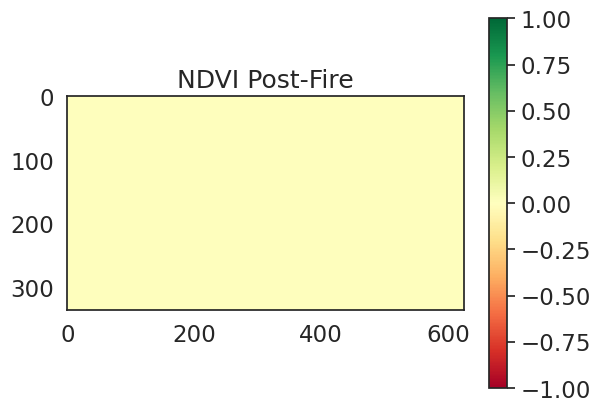

In [124]:
print('Max NDVI: {m}'.format(m=ndvi_post.max()))
print('Mean NDVI: {m}'.format(m=ndvi_post.mean()))
print('Median NDVI: {m}'.format(m=np.median(ndvi_post)))
print('Min NDVI: {m}'.format(m=ndvi_post.min()))

plt.imshow(ndvi_post, cmap="RdYlGn", vmin=-1, vmax=1)
plt.colorbar()
plt.title("NDVI Post-Fire")
plt.show()

# #5

In [80]:
#5 Write a few sentences of what differences you see between the RGB/NDVI maps.

Comparison:
* Unsure why my post-fire plot is grayscale, but you should see less greenery/vegetation in the post-fire plot.
* Comparing the NDVI, the lighter areas (below 0.00) should be more prominent in the NDVI post-fire plot.